In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import json
from myGenerator import DataGenerator
import CustomLayers as cl

### Carga de datos

In [2]:
train = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/PanTrain.plk")
val = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/PanVal.plk")
# test = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/PanTest.plk")
# docDict = pd.read_pickle("pan22-authorship-verification-training-dataset/particionesXid/UniquePanDocs.plk")

In [3]:
def spectraLoader(inputPath: str) -> pd.DataFrame:
    df = pd.DataFrame()
    with open(inputPath, encoding='utf-8') as f:
        for line in f:
            jsonline = json.loads(line)
            lineDf = pd.DataFrame({'id':jsonline['id'], 'spectra':[np.array(jsonline['spectra'])]})
            df = pd.concat([df, lineDf])
    df = df.reset_index(drop=True)

    return df

In [4]:
full_spectra = spectraLoader("pan22-authorship-verification-training-dataset/particionesXid/FullSpectra.jsonl")

In [5]:
def loadLabels(inputPath:str, labelDict:dict) -> dict:
    with open(inputPath, encoding='utf-8') as f:
        for line in f:
            jsonline = json.loads(line)
            labelDict[jsonline['id']] = 1 if jsonline['value'] else 0
        
    return labelDict

In [6]:
labels = dict()
labels = loadLabels('pan22-authorship-verification-training-dataset/particiones/train_truth.jsonl',labels)
labels = loadLabels('pan22-authorship-verification-training-dataset/particiones/val_truth.jsonl',labels)

In [7]:
print("Instances: {}".format((train.shape[0] + val.shape[0])/2))
print("Labels: ",len(labels))

Instances: 16486.0
Labels:  16486


In [8]:
partition = {'train': train.id.unique().tolist(), 'validation': val.id.unique().tolist()}

In [9]:
print("Train: ", len(partition['train']))
print("Validation: ", len(partition['validation']))
print("Total: ", len(partition['train'])+len(partition['validation']))

Train:  15732
Validation:  754
Total:  16486


### Definición de la arquitectura de red siamesa

In [2]:
x1 = tf.keras.Input(shape=(1200,), name="Input_1")
x2 = tf.keras.Input(shape=(1200,), name="Input_2")

hidden1 = tf.keras.layers.Dense(128, activation='relu', name="hidden_layer1")
h1 = hidden1(x1)
h2 = hidden1(x2)

# Dropout
dropout_layer = tf.keras.layers.Dropout(0.4, name="Dropout_1")
d1 = dropout_layer(h1)
d2 = dropout_layer(h2)

# merge = cl.AbsoluteResidual(name="AbsoluteResidual")([o9_1,o9_2])
merge = tf.subtract(d1,d2, name="merge")

# MLPNN Classifier
hidden2 = tf.keras.layers.Dense(128, activation='relu', name="hidden_layer2")(merge)
dropout_layer2 = tf.keras.layers.Dropout(0.4, name="Dropout_2")(hidden2)
output = tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")(dropout_layer2)

model = tf.keras.Model([x1, x2], output)
model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics=["binary_accuracy"])

2022-05-17 22:52:02.385473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 22:52:02.408207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 22:52:02.408333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 22:52:02.408934: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_1 (InputLayer)           [(None, 1200)]       0           []                               
                                                                                                  
 Input_2 (InputLayer)           [(None, 1200)]       0           []                               
                                                                                                  
 hidden_layer1 (Dense)          (None, 128)          153728      ['Input_1[0][0]',                
                                                                  'Input_2[0][0]']                
                                                                                                  
 Dropout_1 (Dropout)            (None, 128)          0           ['hidden_layer1[0][0]',      

### Entrenamiento de red siamesa

In [12]:
# Parameters
params = {'dim': (1200,),
            'batch_size': 32,
            'shuffle': True}

In [13]:
# Generators
training_generator = DataGenerator(partition['train'], train, labels, full_spectra, **params)
validation_generator = DataGenerator(partition['validation'], val, labels, full_spectra, **params)

In [14]:
tf.test.gpu_device_name()

2022-05-17 22:34:00.579827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 22:34:00.580009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 22:34:00.580088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 22:34:00.580205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 22:34:00.580286: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

'/device:GPU:0'

In [15]:
# Train model on dataset
# with tf.device('/device:GPU:0'):
history = model.fit(x=training_generator,
                    validation_data=validation_generator,
                    # use_multiprocessing=True,
                    # workers=4,
                    epochs=10,
                    verbose=1)

Epoch 1/10
  5/491 [..............................] - ETA: 20s - loss: 23.6725 - binary_accuracy: 0.5188

2022-05-17 22:34:20.760170: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


491/491 [==============================] - 29s 57ms/step - loss: 1.4141 - binary_accuracy: 0.4952 - val_loss: 0.6931 - val_binary_accuracy: 0.5054
Epoch 2/10
491/491 [==============================] - 28s 57ms/step - loss: 0.6913 - binary_accuracy: 0.5022 - val_loss: 0.6931 - val_binary_accuracy: 0.5068
Epoch 3/10
491/491 [==============================] - 28s 57ms/step - loss: 0.6919 - binary_accuracy: 0.4973 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 4/10
491/491 [==============================] - 28s 57ms/step - loss: 0.6932 - binary_accuracy: 0.4994 - val_loss: 0.6932 - val_binary_accuracy: 0.4946
Epoch 5/10
491/491 [==============================] - 28s 57ms/step - loss: 0.6932 - binary_accuracy: 0.5011 - val_loss: 0.6932 - val_binary_accuracy: 0.4946
Epoch 6/10
491/491 [==============================] - 28s 57ms/step - loss: 0.6932 - binary_accuracy: 0.4983 - val_loss: 0.6932 - val_binary_accuracy: 0.4973
Epoch 7/10
491/491 [==============================] - 28s 57ms/

In [4]:
model.save('models/SiameseNetwork-DUMMY')

2022-05-17 22:52:16.581378: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/SiameseNetwork-DUMMY/assets


INFO:tensorflow:Assets written to: models/SiameseNetwork-DUMMY/assets


### Resultados del entrenamiento

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [18]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [19]:
acc = pd.DataFrame({'accuracy':history.history['binary_accuracy'], 'type':'train'}).reset_index().rename(columns={'index':'epoch'})
acc = pd.concat([acc, pd.DataFrame({'accuracy':history.history['val_binary_accuracy'], 'type':'val'}).reset_index().rename(columns={'index':'epoch'})]).reset_index(drop=True)
loss = pd.DataFrame({'loss':history.history['loss'], 'type':'train'}).reset_index().rename(columns={'index':'epoch'})
loss = pd.concat([loss, pd.DataFrame({'loss':history.history['val_loss'], 'type':'val'}).reset_index().rename(columns={'index':'epoch'})]).reset_index(drop=True)

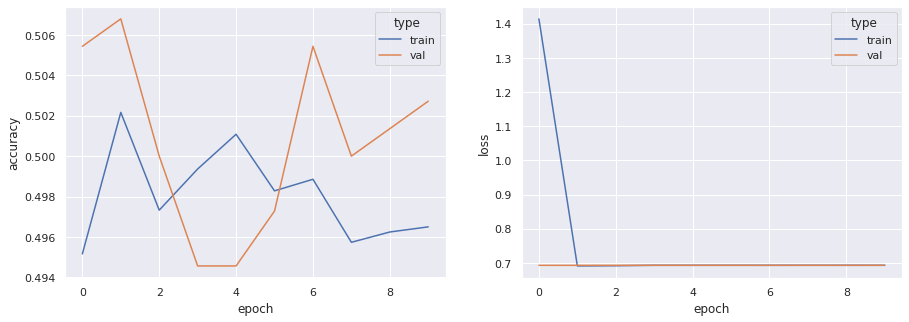

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.lineplot(x='epoch', y='accuracy', data=acc, hue='type', ax=ax[0])
sns.lineplot(x='epoch', y='loss', data=loss, hue='type', ax=ax[1])
plt.show()

In [23]:
acc.loc[acc.epoch==9]

,epoch,accuracy,type
9,9,0.496499,train
19,9,0.502717,val


In [24]:
loss.loc[loss.epoch==9]

,epoch,loss,type
9,9,0.693212,train
19,9,0.693147,val
